Comparing methods for dynamic functional connectivity in brain imaging
--
This notebook implements clustering methods

In [8]:
import numpy as np 

import os 
datapath = '/Users/nicolasfarrugia/Documents/recherche/data_mpilmbb/'

from matplotlib import pyplot as plt 

%matplotlib inline

from nilearn.plotting import plot_matrix, plot_connectome


The following cell extracts the baricenters of the regions from the atlas and creates a 3 x 93 arrays of ROI center coordinates 

In [10]:
# Current ATLAS  
roi_maps = 'basc_2mm_scale064.nii.gz'

from nilearn.plotting import plot_prob_atlas,plot_roi
from nilearn.regions import connected_label_regions

labels_maps = connected_label_regions(roi_maps)

from nilearn.image import math_img
from nilearn.image import iter_img

from nilearn.plotting import find_xyz_cut_coords

nrois = np.unique(labels_maps.get_data())[-1]

roi_maps_4D = []

for i in range(1,nrois+1):
    curimg = math_img('img == %d' % i ,img=labels_maps)
    roi_maps_4D.append(curimg)
    

coords_connectome = [find_xyz_cut_coords(img) for img in iter_img(roi_maps_4D)]
coords_connectome = np.stack(coords_connectome)


Load FC matrices

In [22]:
all_FC_sl = np.load(os.path.join(datapath,'FC_matrices.npz'))['FCmatrices']

K-means Clustering
--

Utility function to average FC matrices according to clustering labels 

In [12]:
def labels_to_FC(FCmatrices,clusterlabels):
    """
        Averages FC matrices according to clustering labels.
        Returns an average state estimated for each subject 
        
        Parameters
        ----------
        FCmatrices: {array-like}, shape = (n_subjects , n_sl , n_regions,n_regions)
           Functional connectivity matrices obtained from n_sl sliding windows, for a group of n_subjects subjects
        clusterlabels: {array-like}, shape = (n_subjects , n_sl)
           Estimated labels for each FCmatrix, per subject
        
        Returns
        -------
        dfcStates : Array-like (n_states,n_subjects,n_regions,n_regions)
           Average state estimated for each subject 
    """
    nstates = np.shape(np.unique(clusterlabels))[0]
    nroi = FCmatrices.shape[2]
    nsubj = FCmatrices.shape[0]

    dfcKmeans_meanstate = np.ndarray((nstates,nsubj,nroi,nroi))

    for curstate in range(nstates):
        for s,cursubjFC in enumerate(FCmatrices):
            labels_list = clusterlabels[s] == curstate
            dfcKmeans_meanstate[curstate,s] = np.mean(cursubjFC[labels_list],axis=0)
    return dfcKmeans_meanstate

First, let's just use Kmeans with minibatches to estimate a set of states. 

We will set the batch size to the number of windows per subject.

all_FC_sl has to be reshape to have the form (nsamples,nfeatures).

In [23]:
from sklearn.cluster import MiniBatchKMeans

nclust = 5
batch_size = all_FC_sl.shape[1]
reassignement = 0.01

kclust = MiniBatchKMeans(n_clusters=nclust,batch_size=batch_size,init='random',reassignment_ratio=reassignement)

kclust.fit(all_FC_sl.reshape((all_FC_sl.shape[0]*all_FC_sl.shape[1],all_FC_sl.shape[2])))

MiniBatchKMeans(batch_size=637, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

Reshape the cluster_centers so that they look like a matrix, and plot the resulting matrices

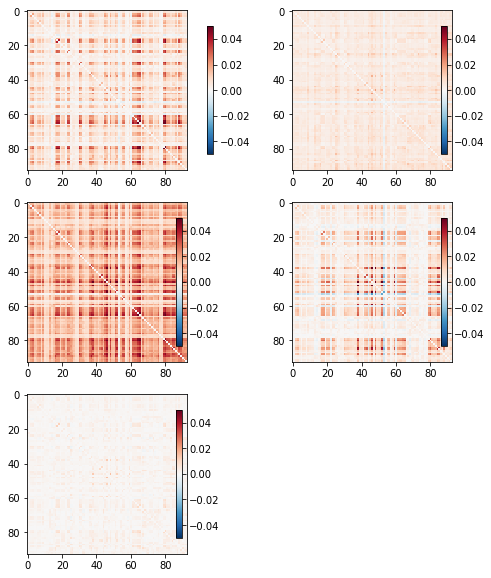

In [34]:
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

centroids = np.ndarray((kclust.n_clusters,93,93))
plt.figure(figsize=(10,10))
for i in range(centroids.shape[0]):
    centroids[i] = vec_to_sym_matrix(kclust.cluster_centers_[i],diagonal=np.zeros(93))
    ax = plt.subplot(3,2,i+1)
    plot_matrix(centroids[i],axes=ax,vmin = -0.05,vmax=0.05)

(93, 93)

2-step K-means Clustering on FC matrices 
--

The DynamicConnectivityKmeans() object implements the estimation of K-means states directly from the time series. 

It estimates a first K-means using high variance FC windows, and uses the estimated clusters in a second K-means initialized using the output of the first clustering. 

In [ ]:
from dfc import DynamicConnectivityKmeans

DynamicConnectivityKmeans?

WARNING : next cell is extremely computationally expensive 

In [ ]:
dfc_kmeans = DynamicConnectivityKmeans(n_states=3,ws=30,saveas='test_kmeans')

dfc_kmeans.fit(allts)

The object has attributes corresponding to the results : cluster labels and states

In [ ]:
dfc_kmeans.states['correlation'].shape

In [ ]:
dfc_kmeans.labels['correlation'].shape

We can plot the time series of the states

In [ ]:
cursubj = 23
plt.plot(dfc_kmeans.labels['correlation'][cursubj])

And let's plot the estimated centroids

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
plot_matrix(dfc_kmeans.states['correlation'][0,:],axes=ax,vmin=-0.8,vmax=0.8)

ax = plt.subplot(2,2,2)
plot_matrix(dfc_kmeans.states['correlation'][1,:],axes=ax,vmin=-0.8,vmax=0.8)

ax = plt.subplot(2,2,3)
plot_matrix(dfc_kmeans.states['correlation'][2,:],axes=ax,vmin=-0.8,vmax=0.8)

Instead of plotting centroids, let's average all FC matrices that belong to a certain label. 

In [ ]:
dfcKmeans_meanstate = labels_to_FC(all_FC_sl,dfc_kmeans.labels['correlation'])

In [ ]:
dfcKmeans_mean_acrosssubject = np.nanmean(dfcKmeans_meanstate,axis=1)

Plot the estimated states

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
plot_matrix(dfcKmeans_mean_acrosssubject[0],axes=ax)

ax = plt.subplot(2,2,2)
plot_matrix(dfcKmeans_mean_acrosssubject[1],axes=ax)

ax = plt.subplot(2,2,3)
plot_matrix(dfcKmeans_mean_acrosssubject[2],axes=ax)

In [ ]:
plt.hist(np.ravel(dfc_kmeans.labels['correlation']))